In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.distributions.uniform import Uniform

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [5]:
inputs = torch.tensor([[1.,0.,0.,0.],
                      [0.,1.,0.,0.],
                      [0.,0.,1.,0.],
                      [0.,0.,0.,1.]])

labels = torch.tensor([[0.,1.,0.,0.],
                      [0.,0.,1.,0.],
                      [0.,0.,0.,1.],
                      [0.,1.,0.,0.]])

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)


In [6]:
class WordEmbedding(nn.Module):
    def __init__(self, embedding_dim=2):
        super().__init__()
        min_value = -0.5
        max_value = 0.5

        # Input embeddings
        self.input_weights = nn.Parameter(
            Uniform(min_value, max_value).sample((4, embedding_dim))
        )

        # Output weights
        self.output_weights = nn.Parameter(
            Uniform(min_value, max_value).sample((4, embedding_dim))
        )

        self.loss = nn.CrossEntropyLoss()

    def forward(self, input_tensor):
        # Get the embedding for the input word
        batch_size = input_tensor.size(0)
        embedded = torch.matmul(input_tensor, self.input_weights)

        # Generate output scores
        output = torch.matmul(embedded, self.output_weights.t())
        return output

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.01)

    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = self.loss(output_i, torch.argmax(label_i, dim=1))
        return loss

    def get_word_vectors(self):
        return self.input_weights.detach()

In [8]:
def test_word_embedding_improved():
    # vocabulary mapping
    vocab = {
        0: "word1",
        1: "word2",
        2: "word3",
        3: "word4"
    }

    inputs = torch.eye(4)
    labels = torch.roll(torch.eye(4), shifts=-1, dims=0)

    dataset = TensorDataset(inputs, labels)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


    model = WordEmbedding(embedding_dim=2)
    optimizer = Adam(model.parameters(), lr=0.05)

    num_epochs = 2000
    best_loss = float('inf')

    losses = []

    print("Starting training...")
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch in dataloader:
            optimizer.zero_grad()
            loss = model.training_step(batch, None)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            epoch_loss += loss.item()

        losses.append(epoch_loss)
        if (epoch + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    print("\nPredictions:")
    model.eval()
    with torch.no_grad():
        test_input = torch.eye(4)
        predictions = model(test_input)
        predicted_indices = torch.argmax(predictions, dim=1)

        for i, pred_idx in enumerate(predicted_indices):
            input_word = vocab[i]
            predicted_word = vocab[pred_idx.item()]
            print(f"{input_word} -> {predicted_word}")

    word_vectors = model.get_word_vectors().numpy()

    plt.figure(figsize=(10, 8))

    for i in range(len(word_vectors)):
        next_i = (i + 1) % len(word_vectors)
        plt.arrow(word_vectors[i, 0], word_vectors[i, 1],
                 word_vectors[next_i, 0] - word_vectors[i, 0],
                 word_vectors[next_i, 1] - word_vectors[i, 1],
                 head_width=0.05, head_length=0.1, fc='gray', ec='gray', alpha=0.5)


    plt.scatter(word_vectors[:, 0], word_vectors[:, 1], c='blue')


    for i, word in vocab.items():
        plt.annotate(word,
                    (word_vectors[i, 0], word_vectors[i, 1]),
                    xytext=(5, 5), textcoords='offset points')

    plt.title("Word Embeddings Visualization\n(arrows show word sequence)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

    return model, word_vectors

Starting training...
Epoch [100/1000], Loss: 0.4370
Epoch [200/1000], Loss: 0.0452
Epoch [300/1000], Loss: 0.0142
Epoch [400/1000], Loss: 0.0074
Epoch [500/1000], Loss: 0.0046
Epoch [600/1000], Loss: 0.0032
Epoch [700/1000], Loss: 0.0023
Epoch [800/1000], Loss: 0.0018
Epoch [900/1000], Loss: 0.0014
Epoch [1000/1000], Loss: 0.0011

Testing the model...

Predictions:
word1 -> word2
word2 -> word3
word3 -> word4
word4 -> word1


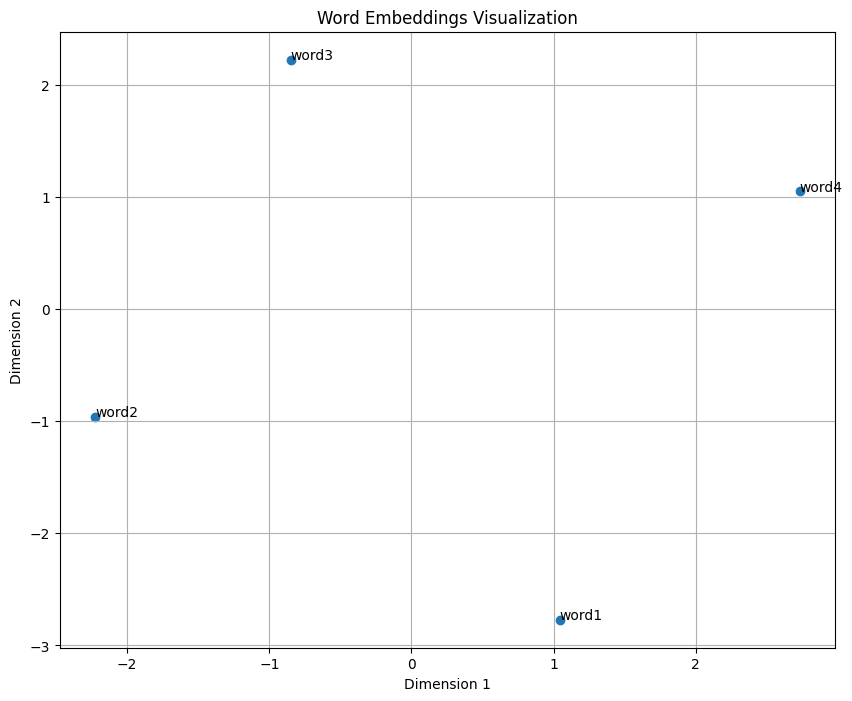

In [9]:
model = test_word_embedding()